In [1]:
import sys; 
sys.path.insert(0, '..')

In [2]:
import findspark
findspark.init()

# Data Exploration
#### Read data from csv file

In [3]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

spark = SparkSession.builder.appName("pyspark-1").getOrCreate()

df_spark = spark.read.options(inferSchema='True').option('escape','"').csv("/dataset/nyc-jobs.csv", header=True)
#Converting to Pandas for easy analysis
df=df_spark.toPandas()
#df_spark.printSchema()

### Data Analysis

#### 1) Job Posting Type
###### From the first visualization we will see the number of position for internal or external posting. Internal postings available to City employees and external postings available to the general public are included.

###### we can conclude that there more number of job vacancies available for city employees then compared to external posting.

([<matplotlib.patches.Wedge at 0x7f7626867c18>,
 [Text(0.23067925815304496, 1.0755403664474714, 'External'),
  Text(-0.2306793588524011, -1.0755403448497156, 'Internal')],
 [Text(0.12582504990166088, 0.5866583816986207, '43.27%'),
  Text(-0.12582510482858242, -0.5866583699180267, '56.73%')])

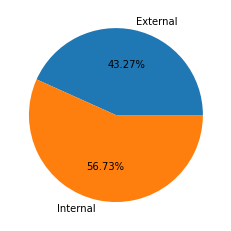

In [4]:
import matplotlib.pyplot as plt

df.groupby(['Posting Type'])['# Of Positions'].sum()

job_type=df.groupby(['Posting Type'])['# Of Positions'].sum().index
postion_values=df.groupby(['Posting Type'])['# Of Positions'].sum().values

plt.pie(postion_values,labels=job_type,autopct='%1.2f%%')

#### 2)FInding the Missing values in each columns

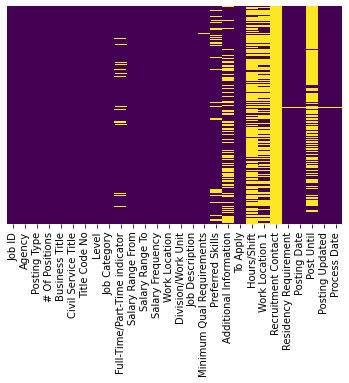

In [5]:
#{i:df.where(f.col(i).isNull()).count() for i in df.columns}
df=df_spark.toPandas()
#Total Columns
len(list(df.columns))

#Total Null values in each column
df.isnull().sum().sort_values()

#Percentage of NULL values in each columns
df.isnull().mean().sort_values()

#Heatmap of missing values of each columns
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

##### Removing Null values using already created function gap_filling_by_mode from utils.gap_filling library.

In [6]:
from utils.gap_filling import gap_filling_by_mode

In [7]:
df_spark=gap_filling_by_mode(df_spark,['Salary Frequency'],'Full-Time/Part-Time indicator')

df_spark=gap_filling_by_mode(df_spark,['Posting Type','Agency'],'Posting Date')

##### Missing value histogram after the gap filling for 'Full-Time/Part-Time indicator' and 'Posting Date'

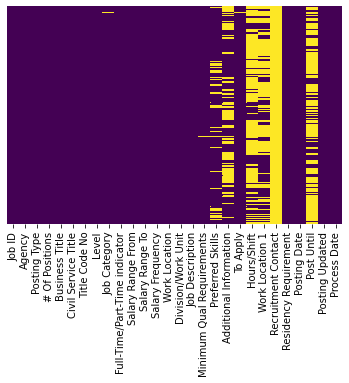

In [8]:
df=df_spark.toPandas()

#Heatmap of missing values of each columns
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### 3) Agencies with higher job postings
###### Through this visualization will check Top 10 agencies providing highest job vacancies. We can conclude that Department of Environmental protection has highest no of job vacancies followed by health, NYC housing.

([<matplotlib.patches.Wedge at 0x7f76265a81d0>,
 [Text(0.5050885298762611, 0.977182468624687, 'DEPT OF ENVIRONMENT PROTECTION'),
  Text(-1.0927376936637825, 0.12619165125458054, 'NYC HOUSING AUTHORITY'),
  Text(-0.36186716141966757, -1.0387743534984257, 'DEPT OF PARKS & RECREATION'),
  Text(0.5533155515643553, -0.9507060010313564, 'DEPARTMENT OF TRANSPORTATION'),
  Text(1.0346568878627072, -0.37347707345733755, 'DEPT OF HEALTH/MENTAL HYGIENE')],
 [Text(0.27550283447796053, 0.5330086192498292, '34.81%'),
  Text(-0.5960387419984268, 0.06883180977522574, '26.71%'),
  Text(-0.19738208804709137, -0.5666041928173231, '16.28%'),
  Text(0.3018084826714665, -0.5185669096534671, '11.17%'),
  Text(0.5643583024705675, -0.20371476734036592, '11.03%')])

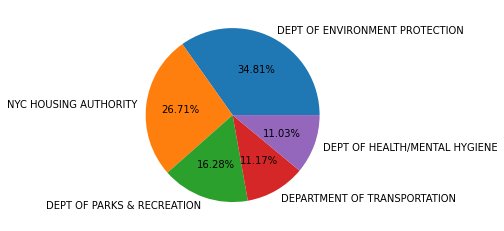

In [9]:
import matplotlib.pyplot as plt

len(list(df['Agency'].unique()))
#df['Agency'].value_counts().sort_values(ascending=False)#.head(10).plot.bar()
df.groupby(['Agency'])['# Of Positions'].sum().sort_values(ascending=False).head(10)

agency_names=df.groupby(['Agency'])['# Of Positions'].sum().sort_values(ascending=False).head(10).index
postion_values=df.groupby(['Agency'])['# Of Positions'].sum().sort_values(ascending=False).head(10).values

plt.pie(postion_values[:5],labels=agency_names[:5],autopct='%1.2f%%')

### 4) Creating additional columns
#### Challenges:
##### 1) Salary Frequency is not uniform, so its better to bring it to a common frequency. Here I took, DAILY as common frequency.
##### 2) Salary can be used for analysis purpose if its a fixed values instead of range.
##### 3) Year and month can be extracted from POSTING DATE and PROCESS DATE for analysis in year and month level
##### 4) Fill the missing values 

### Additional columns for salary, salary_avg, daily_salary_avg

In [10]:
from utils.avg_sal import get_avg_sal
from utils.daily_avg_sal import get_daily_avg_sal

# Creating Feature salary_avg for quantifying salary across multiple job titles
df_spark=get_avg_sal(df_spark, "Salary Range From","Salary Range To")
# Creating Feature daily_salary_avg for normalizing salary across multiple job titles irrspective of Salary Frquency
df_spark=get_daily_avg_sal(df_spark, "salary_avg","Salary Frequency")

### Additional columns for month and year

In [11]:
from utils.year_month import get_year_month

df_spark=get_year_month(df_spark,"Posting Date", "Job_Post_Year","Job_Post_Month")
df_spark=get_year_month(df_spark,"Process Date", "data_processed_year","data_processed_month")


#### 5) Tremendous increase in job positions in each year, especially on 2019

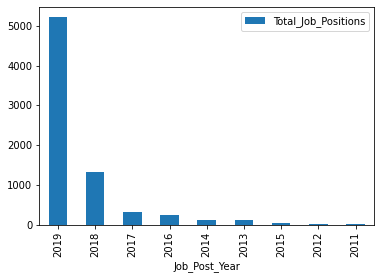

In [12]:
import pyspark.sql.functions as f
df_spark.groupBy('Job_Post_Year').agg(f.sum('# Of Positions').alias('Total_Job_Positions'))\
.sort(f.col('Total_Job_Positions')\
      .desc()).limit(10).toPandas().set_index('Job_Post_Year').plot.bar()


#### 6) Maximum job postions has been posted on December 2019

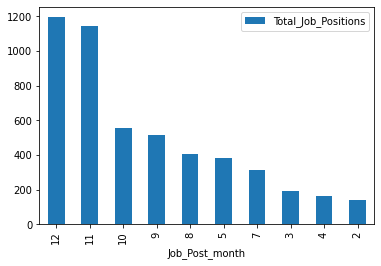

In [13]:
df_spark.filter(df_spark.Job_Post_Year == 2019).groupBy('Job_Post_month').agg(f.sum('# Of Positions').alias('Total_Job_Positions'))\
.sort(f.col('Total_Job_Positions')\
      .desc()).limit(10).toPandas().set_index('Job_Post_month').plot.bar()

#### 7) There is a high requirement of Security Guard jobs in 2019 

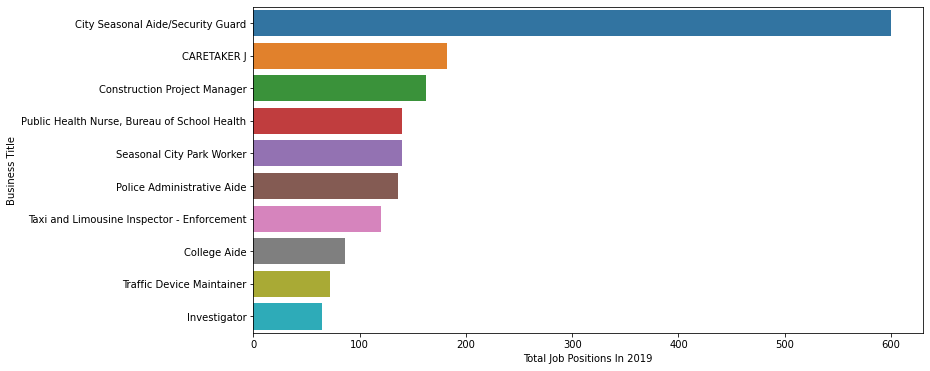

In [14]:
import matplotlib
df=df_spark.toPandas()
matplotlib.rcParams['figure.figsize']=(12,6)
df_job_trends=df[df['Job_Post_Year']==2019].groupby(['Business Title'])['# Of Positions']\
.sum().sort_values(ascending=False).reset_index().rename(columns={'# Of Positions':'Total Job Positions In 2019'}).head(10)
sns.barplot(x='Total Job Positions In 2019', y='Business Title',data=df_job_trends)

## List of KPIs to be resolved

#### 1) What's the number of jobs posting per category (Top 10)?

In [15]:
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType,BooleanType,DateType

df_spark.createOrReplaceTempView("nyc_job_data")

def sum_per_category(dataframe,category_col,aggregate_col,alias_col_name,num_of_output_recs):
    # dataframe : The input dataframe
    # category_col : The column name used for categorizing the aggregate functionality
    # aggregate_col : The column name used for performing Aggregate functions
    # alias_col_name : The alias column name for the aggragated results
    # num_of_output_recs : Number of result records
    
    # Will convert the aggregate column to Integer type for performing aggregate functions
    df_final = dataframe.withColumn(aggregate_col,dataframe[aggregate_col].cast(IntegerType()))
    
    #Returning final result with aggregated data
    return df_final.groupBy(category_col).agg(f.count(aggregate_col).alias(alias_col_name)).sort(f.col(alias_col_name).desc()).limit(num_of_output_recs)

df_Num_job_posting = sum_per_category(df_spark,"Job Category","# Of Positions","Num_Job_Posting",10)
df_Num_job_posting.show(truncate=False)

+-----------------------------------------+---------------+
|Job Category                             |Num_Job_Posting|
+-----------------------------------------+---------------+
|Engineering, Architecture, & Planning    |504            |
|Technology, Data & Innovation            |313            |
|Legal Affairs                            |226            |
|Public Safety, Inspections, & Enforcement|182            |
|Building Operations & Maintenance        |181            |
|Finance, Accounting, & Procurement       |169            |
|Administration & Human Resources         |134            |
|Constituent Services & Community Programs|129            |
|Health                                   |125            |
|Policy, Research & Analysis              |124            |
+-----------------------------------------+---------------+



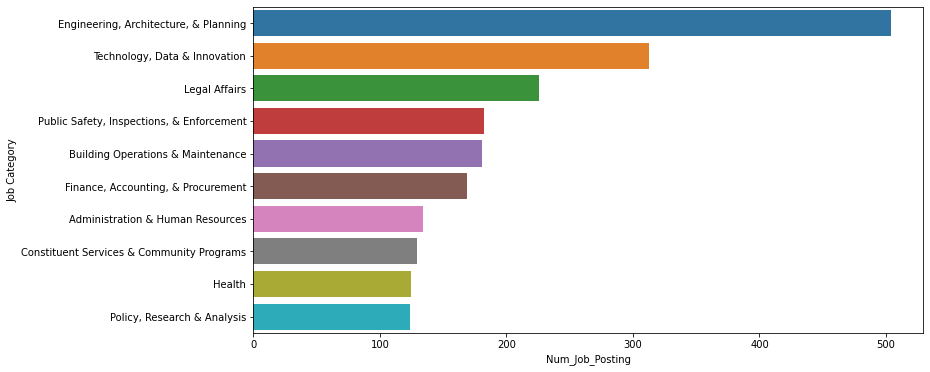

In [16]:
df_Num_job_posting_pd=df_Num_job_posting.toPandas()
sns.barplot(x='Num_Job_Posting', y='Job Category',data=df_Num_job_posting_pd)

#### 2) What's the salary distribution per job category?

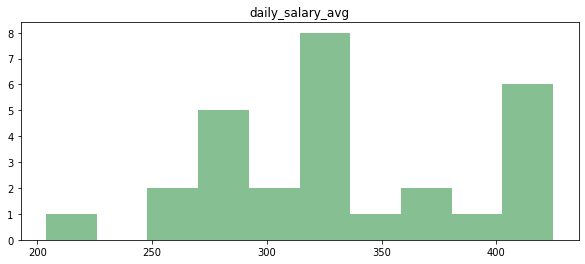

In [17]:
import pyspark.sql.functions as f
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType,BooleanType,DateType

def sal_dist_per_category(dataframe,category_name):
    # dataframe : The input dataframe
    # category_name : The category name for which salary distribution need to be calculated
    
    # Will filter data based on given category and convert to pandas dataframe
    df_pandas = dataframe.filter(f.col("Job Category") == category_name).toPandas()
    
    #Ploting histogram of salary distribution
    df_pandas.hist(column="daily_salary_avg",bins=10,grid=False, figsize=(10,4), color='#86bf91', zorder=2)

sal_dist_per_category(df_spark,"Information Technology & Telecommunications")

#### 3) Is there any correlation between the higher degree and the salary?

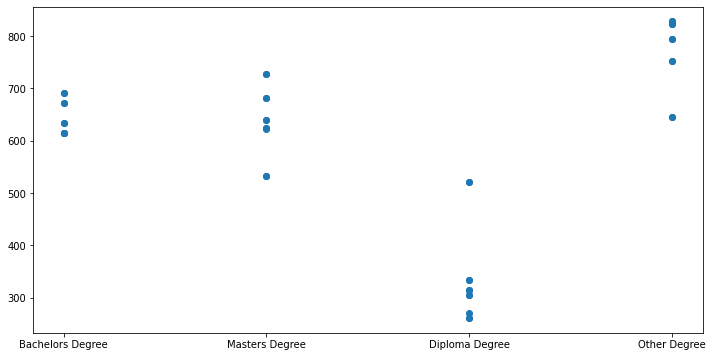

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType,BooleanType,DateType


def corr_sal_degree():
    # dataframe : The input dataframe
    
    # Removing non numerical values from column Level
    df_temp = spark.sql("SELECT case when `Minimum Qual Requirements` like '%master%' THEN 'Masters Degree'\
                                                when `Minimum Qual Requirements` like '%baccalaureate%' THEN 'Bachelors Degree'\
                                                when `Minimum Qual Requirements` like '%diploma%' THEN 'Diploma Degree'\
                                                when `Minimum Qual Requirements` like '%associate%' THEN 'Associate Degree'\
                                                ELSE 'Other Degree'\
                                            end      AS degree_type,\
                                                daily_salary_avg from nyc_job_data")

    # Window function definition
    windowSpec  = Window.partitionBy("degree_type").orderBy(f.col("daily_salary_avg").desc())
    
    #Adding Rank based on avg salary in desc order
    df_temp_final=df_temp.withColumn("rank",f.rank().over(windowSpec))
    
    #Output the records having max salary for each agency
    df_out = df_temp_final.filter(f.col("rank") < 11)
    df_pandas_out=df_out.toPandas()
    plt.scatter(x=df_pandas_out['degree_type'], y=df_pandas_out['daily_salary_avg'])
    
corr_sal_degree()

#### 4) What's the job posting having the highest salary per agency?

In [19]:
import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType,BooleanType,DateType

def max_sal_per_agency(dataframe):
    # dataframe : The input dataframe
   
    
    # Window function definition
    windowSpec  = Window.partitionBy("Agency").orderBy(f.col("Salary_Avg").desc())
    
    #Adding Rank based on avg salary in desc order
    df_max_final=dataframe.withColumn("rank",f.row_number().over(windowSpec))

    #Output the records having max salary for each agency
    return df_max_final.filter(f.col("rank") == 1)

df_max_sal_per_agency = max_sal_per_agency(df_spark)
#df_max_sal_per_agency.show()

##### Below result will give minimum features needed for valuation

In [20]:
df_max_sal_per_agency.select("Agency","Business Title","Salary Range To","Salary Frequency").show(10,truncate=False)

+------------------------------+----------------------------------------------------+---------------+----------------+
|Agency                        |Business Title                                      |Salary Range To|Salary Frequency|
+------------------------------+----------------------------------------------------+---------------+----------------+
|LANDMARKS PRESERVATION COMM   |LANDMARKS PRESERVATIONIST, PRESERVATION DEPT        |64297          |Annual          |
|OFFICE OF COLLECTIVE BARGAININ|COLLEGE AIDE - CLERICAL                             |10             |Hourly          |
|FIRE DEPARTMENT               |Senior Enterprise Applications Integration Developer|144929         |Annual          |
|ADMIN FOR CHILDREN'S SVCS     |Assistant Commissioner                              |156375         |Annual          |
|MANHATTAN COMMUNITY BOARD #8  |Community Assistant                                 |19             |Hourly          |
|TAX COMMISSION                |CITY ASSESSOR   

#### 5) What's the job postings average salary per agency for the last 2 years?
##### Took top 15 Agencies

In [21]:
import pyspark.sql.functions as f
from pyspark.sql.functions import when
def avg_sal_per_agency(dataframe):
    # dataframe : The input dataframe
    
   
    #FIlter data for last 2 years
    df_temp = dataframe.filter(dataframe["Job_Post_Year"]>=dataframe["data_processed_year"]-1)
    
    #Average slaray per agency in last 2 years
    return df_temp.groupBy("Agency").agg(f.avg("daily_salary_avg")\
                                         .alias("avg_daily_salary_per_agency")).orderBy("avg_daily_salary_per_agency"\
                                                                                        ,ascending=False).limit(15)

df_avg_sal_per_agency = avg_sal_per_agency(df_spark)
df_avg_sal_per_agency.show(truncate=False)

+------------------------------+---------------------------+
|Agency                        |avg_daily_salary_per_agency|
+------------------------------+---------------------------+
|CONFLICTS OF INTEREST BOARD   |511.3636363636364          |
|NYC EMPLOYEES RETIREMENT SYS  |372.4849537037037          |
|BOARD OF CORRECTION           |364.4791666666667          |
|FINANCIAL INFO SVCS AGENCY    |363.71639784946234         |
|DEPARTMENT OF SANITATION      |354.3200757575758          |
|NYC HOUSING AUTHORITY         |340.2525488530161          |
|DEPT OF INFO TECH & TELECOMM  |339.1963594276095          |
|DEPT OF DESIGN & CONSTRUCTION |332.76264404609475         |
|MAYORS OFFICE OF CONTRACT SVCS|330.89826839826844         |
|LAW DEPARTMENT                |329.9404342723004          |
|FIRE DEPARTMENT               |328.47176308539946         |
|NYC DEPT OF VETERANS' SERVICES|313.07954545454544         |
|BUSINESS INTEGRITY COMMISSION |311.0505952380953          |
|DEPARTMENT OF CORRECTIO

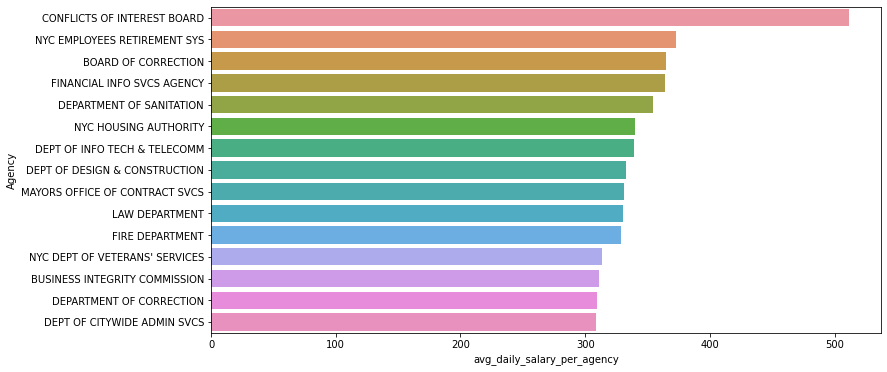

In [22]:
df_avg_sal_per_agency_pd=df_avg_sal_per_agency.toPandas()
sns.barplot(x='avg_daily_salary_per_agency', y='Agency',data=df_avg_sal_per_agency_pd)

#### 6) What are the highest paid skills in the US market?

In [23]:
import pyspark.sql.functions as f
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType,BooleanType,DateType

def max_sal_per_skill(dataframe,num_of_output_recs):
    # dataframe : The input dataframe
    # num_of_output_recs : Number of result records
    
    #Returning final result with aggregated data
    return dataframe.groupBy("Job Category").agg(f.max("daily_salary_avg").alias("max_daily_salary")).sort(f.col("max_daily_salary").desc()).limit(num_of_output_recs)

df_max_sal = max_sal_per_skill(df_spark,10)
df_max_sal.show(truncate=True)

+--------------------+-----------------+
|        Job Category| max_daily_salary|
+--------------------+-----------------+
|Administration & ...|827.9810606060606|
|Constituent Servi...|822.7310606060606|
|Engineering, Arch...|793.8825757575758|
|Engineering, Arch...|751.9621212121212|
|       Legal Affairs|726.9431818181819|
|Administration & ...|681.8181818181819|
|Administration & ...| 671.873106060606|
|              Health|644.4450757575758|
|Building Operatio...|640.1931818181819|
|Technology, Data ...|640.1931818181819|
+--------------------+-----------------+



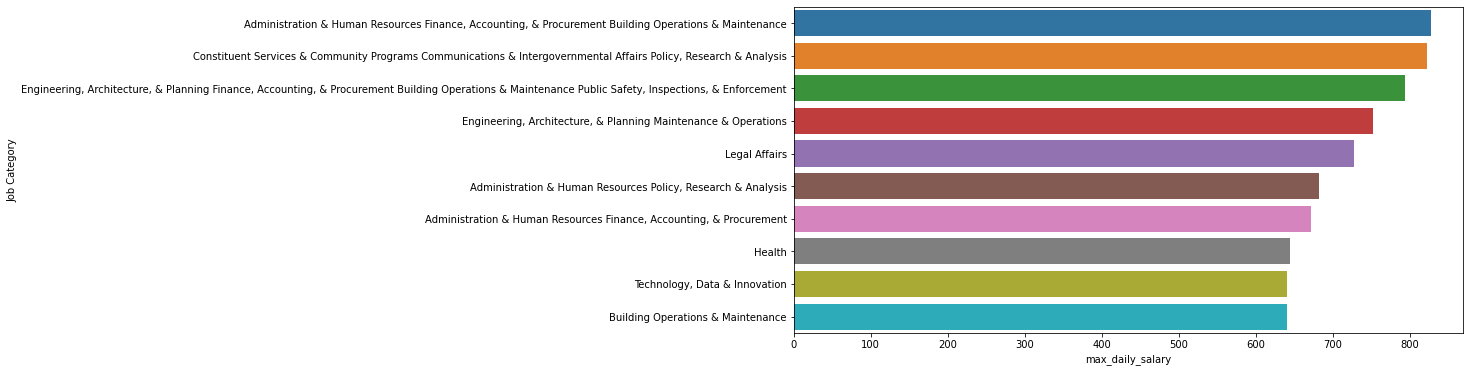

In [24]:
df_max_sal_pd=df_max_sal.toPandas()
sns.barplot(x='max_daily_salary', y='Job Category',data=df_max_sal_pd)